# Deep Learning for Music and Audio
#### Final Project Experiments
Jordie Shier - j.m.shier@qmul.ac.uk

This notebook includes a set of experiments conducted on the Mridangam dataset. 
The Mridangam is a pitch percussion instrument.
The dataset includes a set of samples with a single percussion hit paired
with labels for the tonic (pitch) and stroke type.

The first two experiments look at different deep learning based models for two separate
tasks:
1. Pitch estimation using Crepe embeddings followed by a simpler linear projection
to classify the tonic (fundamental frequency) of the instrument.
2. Transient/Stationary separation (TSS) using temporal convolutions and a 
self-supervised learning paradigm.

The next two experiments look at methods for incorporating this two tasks into one.
1. Using crepe embeddings as an additional conditioning feature for TSS.
2. Using the results from TSS, specifically the stationary signal, as the source for
Crepe embeddings to deterine whether the TSS can help improve prediction accuracy.


All experiments are conducted using PyTorch and PyTorch Lightning. I used a PyTorch
port of Crepe to compute embeddings: https://github.com/maxrmorrison/torchcrepe

In [46]:
from pathlib import Path

import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torchaudio
import torchcrepe
import torch
from tqdm import tqdm

from mridangam.data import MridangamDataModule
from mridangam.loss import ReconstructionLoss
from mridangam.loss import StationaryRegularization
from mridangam.loss import TransientRegularization
from mridangam.models import MLP
from mridangam.models import TCN
from mridangam.tasks import MridangamTonicClassification
from mridangam.tasks import TransientStationarySeparation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Audio File

The audio file that I am interested in examining is a short recording of a Mridangam
recording. There are 24 individual hits in this recording. 

In particular, I am curious to see if I can determine the tonic of the
drum used to create this recording as well as separate the transient and stationary
components to either improve classification or conduct further experiments.

This audio file is available under a creative commons license on Freesound:
https://freesound.org/people/akshaylaya/sounds/173285/

In [3]:
audio, sr = torchaudio.load("mridangam_phrase.wav")
audio = torchaudio.functional.resample(audio, sr, 48000, lowpass_filter_width=512)
ipd.Audio(audio[0].numpy(), rate=48000)

# Dataset

I've created a custom PyTorch Lightning Datamodule to handle loading and pre-processing
of the [Mridangam Stroke Dataset](https://zenodo.org/record/4068196#.ZDw33XbMJD8). 
The following stesp are taken for pre-processing:

For the Crepe experiments:
1. Compute Crepe embeddings using torchcrepe
2. Take the mean of embeddings along the temporal axis
3. The result is a single 2048 dim embedding for a single audio sample
4. Save embeddings to a .pt torch file

For TSS experiments:
1. Resample audio to desired rate of 48kHz
2. Trim or pad the audio to 1 second
3. Save the resulting audio file with the tonic annotation in the filename

The same dataloaders are used for both tonic classification and TSS experiments; the
dataloader returns pre-processed audio, crepe embedding, tonic label for each example.

In [4]:
datamodule = MridangamDataModule(
    dataset_dir="dataset/preprocesed",
    unprocessed_dir="dataset/mridangam_stroke_1.5/",
    batch_size=8,
    num_workers=4,
    attribute="tonic",
    sample_rate=48000,
    device=device,
)

# Load data into memory for experiments
datamodule.prepare_data()

Found 6977 audio files in dataset directory


100%|██████████| 6977/6977 [00:08<00:00, 837.47it/s] 


Instantiate train and validation dataloaders for experiments

In [5]:
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()

# Mridangam Tonic Classification

For this first experiment I am using embeddings generated by Crepe to estimate tonic.

### Model

The model I'm using is a simple linear projection layer from the crepe embedding to
the number of classes. I wrote a MLP class that can use an abitrary number of hidden
layers, but here I use zero as I'm interested in seeing how well we can classify
the Mridangam using crepe embeddings and a very minimal model. 

In [6]:
# Get input feature size and target num_classes from data
_, embedding, label = next(iter(train_dataloader))

in_features = embedding.size(-1)
print("Input feature dimensions: ", in_features)

out_features = train_dataloader.dataset.num_classes
print("Number of classes: ", out_features)

# Create model based on the input features and number of output classes
model = MLP(in_features=in_features, hidden=[], out_features=out_features)
print(model)

Input feature dimensions:  2048
Number of classes:  6
MLP(
  (model): Sequential(
    (0): Linear(in_features=2048, out_features=6, bias=True)
  )
)


### Training Task

I've defined the training task within a PyTorch Lightning Module which uses the model
I've created to estimate tonic. It also instantiates the optimizer, Adam with an
initial learning rate of 1e-3, and creates a learning rate scheduler that reduces the
learning rate by a factor of two if the validation loss has not improved for 5 epochs.
It also calculates the cross entropy loss used to optimization.

In [7]:
task = MridangamTonicClassification(model=model, lr=1e-3, reduce_patience=5)
print(task)

MridangamTonicClassification(
  (model): MLP(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=6, bias=True)
    )
  )
  (loss_fn): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
)


### Training

I'm using a PyTorch Lightning trainer to train my model. I'm using a couple callbacks,
one to log the learning rate (so I can visualize in tensorboard) and the other is an
early stopping callback which halts training if the validation loss has not improved
for 10 epochs, this helps prevent model overfitting.

In [8]:
lr_callback = pl.callbacks.LearningRateMonitor(logging_interval="epoch")
early_stopping = pl.callbacks.EarlyStopping(monitor="validation/loss", patience=10)

trainer = pl.Trainer(max_epochs=-1, accelerator=device, callbacks=[lr_callback, early_stopping])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [73]:
trainer.fit(
    model=task, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | MLP                | 12.3 K
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
12.3 K    Trainable params
0         Non-trainable params
12.3 K    Total params
0.049     Total estimated model params size (MB)


Epoch 48: 100%|██████████| 786/786 [00:06<00:00, 114.51it/s, loss=0.0143, v_num=29] 


In [9]:
# Reload trained model from checkpoint
task = MridangamTonicClassification.load_from_checkpoint(
    "lightning_logs/version_29/checkpoints/epoch=48-step=34202.ckpt",
    model=model,
)

### Testing

Using the test split, compute the accuracy of our trained model

In [10]:
datamodule.setup("test")
test_dataloader = datamodule.test_dataloader()
trainer.test(model=task, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 88/88 [00:02<00:00, 36.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.9727402925491333
        test/loss           0.12550382316112518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.12550382316112518, 'test/accuracy': 0.9727402925491333}]

### Computing the tonic of the file under test

Now let's apply our trained model to the full mridangam phrase and see if it
can determine the correct tonic. I know from the description on the freesound
page the the mridangam in the recording is D sharp.

In [11]:
embedding = torchcrepe.embed(audio, 48000)
embedding = embedding.detach().cpu()
embedding = embedding.flatten(2)
embedding = torch.mean(embedding, dim=1)

In [12]:
# Get the predicted tonic from the model and map to the label
tonic = torch.argmax(task(embedding))
tonic = test_dataloader.dataset.get_label_from_idx(tonic.item())

print("Predicted tonic: ", tonic)

Predicted tonic:  dsh


# Mridangam Stationary/Transient Separation

For the second experiment I am looking at stationary/transient separation (STS). This
is a common task in MIR and is sometimes applied as a pre-processing step. For example,
the stationary component of an audio signal could be extracted prior to pitch detection
(which I explore here) or sinusoidal modeling synthesis.

STS is commonly done by learning magnitude spectrogram masks, but here I am investigating
if this can be done directly in the time domain using temporal convoluations.

### Model

The model I am using is a stack of residual 1D convolutions with exponentionally
increasing levels of dilation. In this model I am using 10 layers and each layer
comprises batch normalization, the main 1D dilated convolution, an activation layer
(GELU), and a residual 1D convolution with kernel of size 1.

In [13]:
tcn = TCN(
    in_channels=1,
    hidden_channels=32,
    out_channels=2,
    dilation_base=2,
    num_layers=10,
    kernel_size=13,
)

### Task

Here I define the task and the learning objective. The TCN model receives as input
audio with single channel and outputs audio with the same number of samples, but now
with two channels. The model is trained to separate the transient and stationary into
each of those channels and to minimize a reconstruction loss on the sum of the channels.

Each channel has a separate frequency domain loss based on [1]. Given a spectrogram,
the difference along the frequency axis is minimized for the transient signal and
the difference along the temporal axis is minimized for the stationary signal.

The full loss is the sum of these losses plus a reconstruction loss that is a sum
of L1Loss on the waveform and a multi-resolution STFT loss.

[1] Roma, Gerard, Owen Green, and Pierre Alexandre Tremblay.
"Stationary/transient audio separation using convolutional autoencoders." 
21st International Conference on Digital Audio Effects. 2018.

In [40]:
transient_loss = TransientRegularization(n_fft=2048, hop_size=512)
stationary_loss = StationaryRegularization(n_fft=2048, hop_size=512)
recon_loss = ReconstructionLoss()

tss_model = TransientStationarySeparation(
    tcn,
    reconstruction_loss=recon_loss,
    transient_loss=transient_loss,
    stationary_loss=stationary_loss,
    learning_rate=5e-4,
    reduce_patience=20,
)

tss_model = tss_model.to(device)

### Training

This model is trained using an Adam optimizer with an inital learning rate of 5e-4 and
the learning rate reduced by a factor of two when the validation loss has not improved
for 20 epochs. Training is halted when validation loss has not improved for 40 epochs.

In [41]:
lr_callback = pl.callbacks.LearningRateMonitor(logging_interval="epoch")
early_stopping = pl.callbacks.EarlyStopping(monitor="validation/loss", patience=40)

trainer = pl.Trainer(max_epochs=200, accelerator=device, callbacks=[lr_callback, early_stopping])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model=tss_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                     | Params
----------------------------------------------------
0 | model  | TCN                      | 144 K 
1 | r_loss | ReconstructionLoss       | 0     
2 | t_loss | TransientRegularization  | 0     
3 | s_loss | StationaryRegularization | 0     
----------------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.579     Total estimated model params size (MB)


Epoch 125: 100%|██████████| 786/786 [01:52<00:00,  6.97it/s, loss=0.363, v_num=17]


In [42]:
# Reload the model from checkpoint
tss_model = TransientStationarySeparation.load_from_checkpoint(
    "lightning_logs/version_17/checkpoints/epoch=125-step=87948.ckpt",
    model=tcn,
    reconstruction_loss=recon_loss,
    transient_loss=transient_loss,
    stationary_loss=stationary_loss,
)

### Testing

In [43]:
datamodule.setup("test")
test_dataloader = datamodule.test_dataloader()
trainer.test(model=tss_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 88/88 [00:04<00:00, 19.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.3830460011959076
     test/mss_error         0.07198639959096909
test/reconstruction_loss    0.06806870549917221
    test/sustain_loss       0.26784664392471313
   test/transient_loss     0.047130782157182693
   test/waveform_error     0.0002959523117169738
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/reconstruction_loss': 0.06806870549917221,
  'test/transient_loss': 0.047130782157182693,
  'test/sustain_loss': 0.26784664392471313,
  'test/loss': 0.3830460011959076,
  'test/waveform_error': 0.0002959523117169738,
  'test/mss_error': 0.07198639959096909}]

### Stationary/Transient Separation on the audio under test

In [18]:
#audio, embedding, label = next(iter(test_dataloader))
test_audio = audio[None].to(device)
tss_model = tss_model.to(device)
trans, sus = tss_model(test_audio)
y_hat = trans + sus

print("Original audio")
ipd.display(ipd.Audio(test_audio[0, 0].detach().cpu().numpy(), rate=48000))

print("Transient")
ipd.display(ipd.Audio(trans[0, 0].detach().cpu().numpy(), rate=48000))

print("Stationary")
ipd.display(ipd.Audio(sus[0, 0].detach().cpu().numpy(), rate=48000))

print("Reconstructed audio")
ipd.display(ipd.Audio(y_hat[0, 0].detach().cpu().numpy(), rate=48000))

Original audio


Transient


Stationary


Reconstructed audio


### Visualize the results

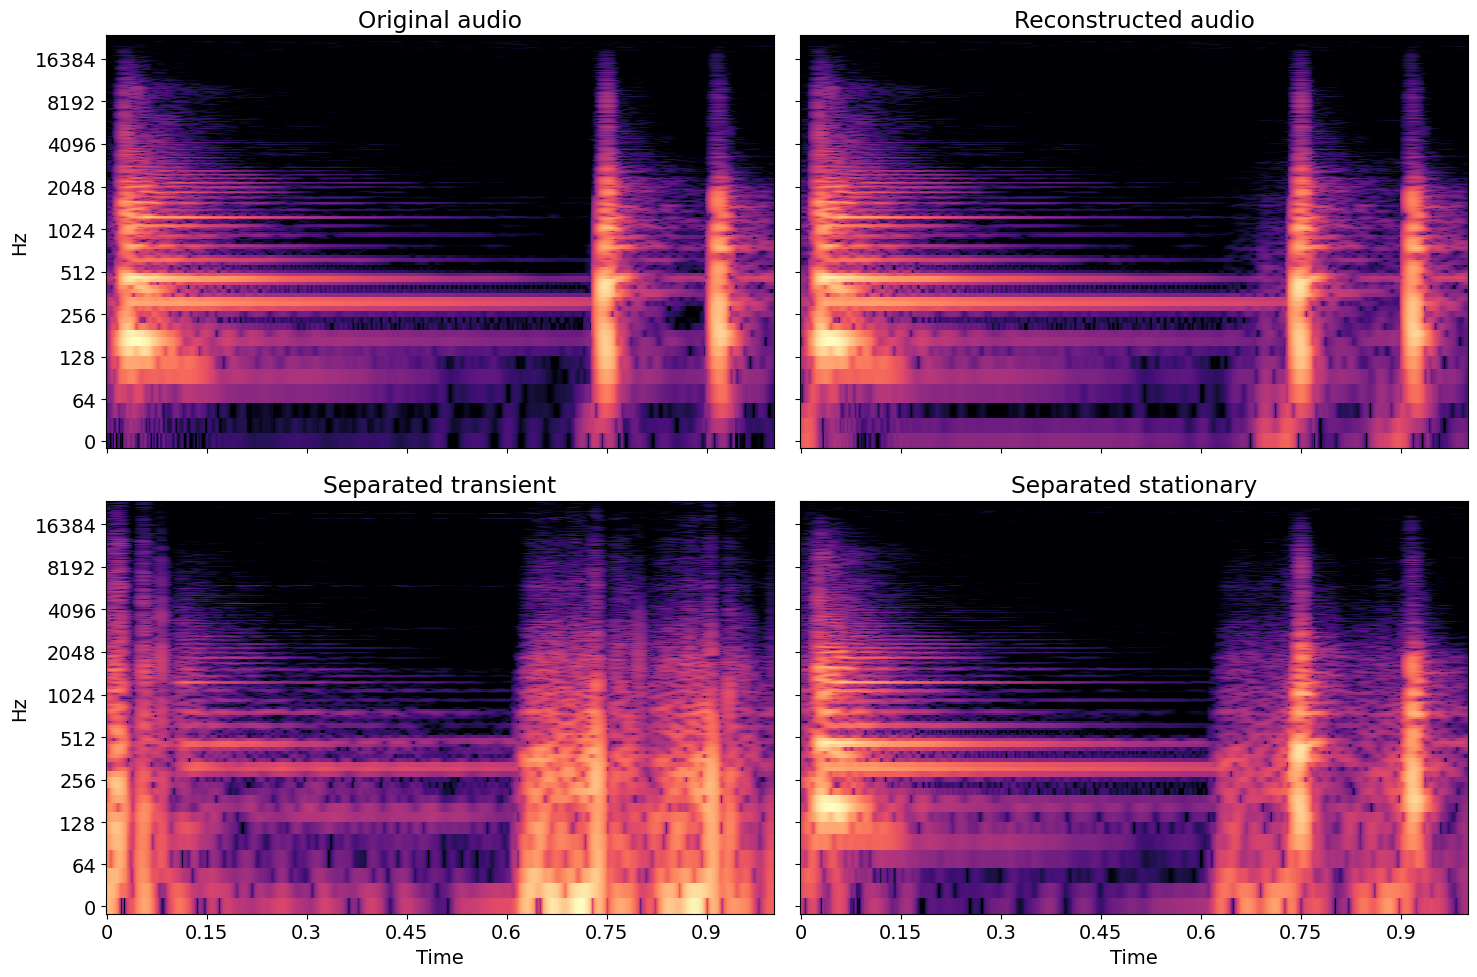

In [19]:
N = 48000
plt.rc('font', size=14)
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Plot the original audio spectrogram
X_orig = librosa.stft(test_audio[0, 0, :N].detach().cpu().numpy(), hop_length=64)
X_orig = librosa.amplitude_to_db(np.abs(X_orig), ref=np.max)
axs[0, 0].set_title("Original audio")
librosa.display.specshow(X_orig, x_axis="time", y_axis="log", ax=axs[0, 0], hop_length=64, sr=48000)

# Plot the reconstructed audio spectrogram
X_hat = librosa.stft(y_hat[0, 0, :N].detach().cpu().numpy(), hop_length=64)
X_hat = librosa.amplitude_to_db(np.abs(X_hat), ref=np.max)
axs[0, 1].set_title("Reconstructed audio")
librosa.display.specshow(X_hat, x_axis="time", y_axis="log", ax=axs[0, 1], hop_length=64, sr=48000)

# Plot the transient spectrogram
X_tr = librosa.stft(trans[0, 0, :N].detach().cpu().numpy(), hop_length=64)
X_tr = librosa.amplitude_to_db(np.abs(X_tr), ref=np.max)
axs[1, 0].set_title("Separated transient")
librosa.display.specshow(X_tr, x_axis="time", y_axis="log", ax=axs[1, 0], hop_length=64, sr=48000)

# Plot the stationary spectrogram
X_st = librosa.stft(sus[0, 0, :N].detach().cpu().numpy(), hop_length=64)
X_st = librosa.amplitude_to_db(np.abs(X_st), ref=np.max)
axs[1, 1].set_title("Separated stationary")
librosa.display.specshow(X_st, x_axis="time", y_axis="log", ax=axs[1, 1], hop_length=64, sr=48000)

for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()

# Combining Approaches

Now we'll pass the embedding generated using Crepe to a FiLM operator that will
modulate each layer of the transient/stationary separation decoder.

This experiment looks at whether passing in additional information to our STS model
can help it improve separation.

The FiLM embedding receives raw crepe embeddings and projects them to a laten embedding
space with a dimensiondality of 128. This encoder is jointly learned with the TCN
model which has the same architecture as the previous experiment.

In [34]:
film_encoder = MLP(in_features=2048, hidden=[256], out_features=128)
tcn_film = TCN(
    in_channels=1,
    hidden_channels=32,
    out_channels=2,
    dilation_base=2,
    num_layers=12,
    kernel_size=3,
    use_film=True,
    film_size=128,
)

### Task + Training

The task and training setup is the same as the previous separation experiment

In [35]:
transient_loss = TransientRegularization()
stationary_loss = StationaryRegularization()
recon_loss = ReconstructionLoss()

tss_film_model = TransientStationarySeparation(
    tcn_film,
    film_encoder=film_encoder,
    reconstruction_loss=recon_loss,
    transient_loss=transient_loss,
    stationary_loss=stationary_loss,
    learning_rate=1e-4,
)

In [36]:
lr_callback = pl.callbacks.LearningRateMonitor(logging_interval="epoch")
early_stopping = pl.callbacks.EarlyStopping(monitor="validation/loss", patience=40)

trainer = pl.Trainer(max_epochs=200, accelerator=device, callbacks=[lr_callback, early_stopping])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model=tss_film_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                     | Params
----------------------------------------------------------
0 | model        | TCN                      | 149 K 
1 | r_loss       | ReconstructionLoss       | 0     
2 | t_loss       | TransientRegularization  | 0     
3 | s_loss       | StationaryRegularization | 0     
4 | film_encoder | MLP                      | 557 K 
----------------------------------------------------------
707 K     Trainable params
0         Non-trainable params
707 K     Total params
2.829     Total estimated model params size (MB)


Epoch 84: 100%|██████████| 786/786 [01:48<00:00,  7.25it/s, loss=0.212, v_num=18]


In [37]:
# Reload the model from checkpoint
tss_film_model = TransientStationarySeparation.load_from_checkpoint(
    "lightning_logs/version_18/checkpoints/epoch=84-step=59330.ckpt",
    model=tcn_film,
    film_encoder=film_encoder,
    reconstruction_loss=recon_loss,
    transient_loss=transient_loss,
    stationary_loss=stationary_loss,
)

### Testing

In [38]:
datamodule.setup("test")
test_dataloader = datamodule.test_dataloader()
trainer.test(model=tss_film_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 88/88 [00:05<00:00, 17.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss            1.337001085281372
     test/mss_error         0.13366647064685822
test/reconstruction_loss    0.12171628326177597
    test/sustain_loss       0.10332565754652023
   test/transient_loss      1.1119590997695923
   test/waveform_error    0.00045267806854099035
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/reconstruction_loss': 0.12171628326177597,
  'test/transient_loss': 1.1119590997695923,
  'test/sustain_loss': 0.10332565754652023,
  'test/loss': 1.337001085281372,
  'test/waveform_error': 0.00045267806854099035,
  'test/mss_error': 0.13366647064685822}]

### Results with the test audio

In [39]:
test_audio = audio[None].to(device)
tss_model = tss_film_model.to(device)

trans, sus = tss_film_model(test_audio, embedding[None].to(device))
y_hat = trans + sus

print("Original audio")
ipd.display(ipd.Audio(test_audio[0, 0].detach().cpu().numpy(), rate=48000))

print("Transient")
ipd.display(ipd.Audio(trans[0, 0].detach().cpu().numpy(), rate=48000))

print("Stationary")
ipd.display(ipd.Audio(sus[0, 0].detach().cpu().numpy(), rate=48000))

print("Reconstructed audio")
ipd.display(ipd.Audio(y_hat[0, 0].detach().cpu().numpy(), rate=48000))

Original audio


Transient


Stationary


Reconstructed audio


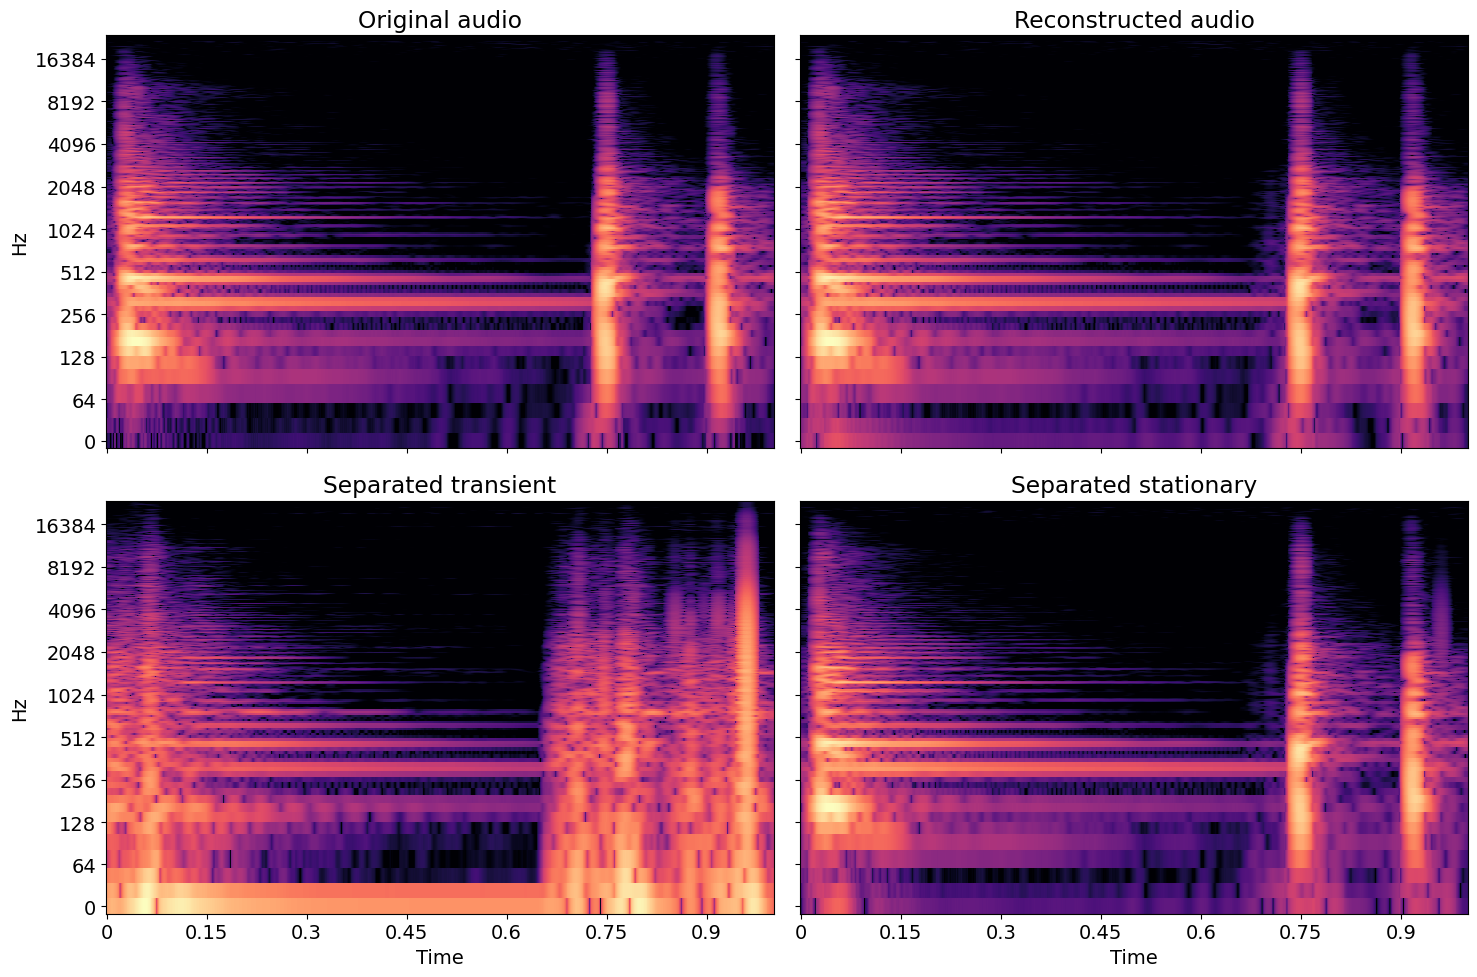

In [28]:
N = 48000
plt.rc('font', size=14)
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Plot the original audio spectrogram
X_orig = librosa.stft(test_audio[0, 0, :N].detach().cpu().numpy(), hop_length=64)
X_orig = librosa.amplitude_to_db(np.abs(X_orig), ref=np.max)
axs[0, 0].set_title("Original audio")
librosa.display.specshow(X_orig, x_axis="time", y_axis="log", ax=axs[0, 0], hop_length=64, sr=48000)

# Plot the reconstructed audio spectrogram
X_hat = librosa.stft(y_hat[0, 0, :N].detach().cpu().numpy(), hop_length=64)
X_hat = librosa.amplitude_to_db(np.abs(X_hat), ref=np.max)
axs[0, 1].set_title("Reconstructed audio")
librosa.display.specshow(X_hat, x_axis="time", y_axis="log", ax=axs[0, 1], hop_length=64, sr=48000)

# Plot the transient spectrogram
X_tr = librosa.stft(trans[0, 0, :N].detach().cpu().numpy(), hop_length=64)
X_tr = librosa.amplitude_to_db(np.abs(X_tr), ref=np.max)
axs[1, 0].set_title("Separated transient")
librosa.display.specshow(X_tr, x_axis="time", y_axis="log", ax=axs[1, 0], hop_length=64, sr=48000)

# Plot the stationary spectrogram
X_st = librosa.stft(sus[0, 0, :N].detach().cpu().numpy(), hop_length=64)
X_st = librosa.amplitude_to_db(np.abs(X_st), ref=np.max)
axs[1, 1].set_title("Separated stationary")
librosa.display.specshow(X_st, x_axis="time", y_axis="log", ax=axs[1, 1], hop_length=64, sr=48000)

for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()

# STS Preprocessing

For the final experiment we'll try using our trained stationary/transient models as
a pre-processing step to crepe embeddings to see if we can improve pitch detection.

### Regular Stationary/Transient Separation Model

In [63]:
# Reload the model from checkpoint
tss_model = TransientStationarySeparation.load_from_checkpoint(
    "lightning_logs/version_17/checkpoints/epoch=125-step=87948.ckpt",
    model=tcn,
    reconstruction_loss=recon_loss,
    transient_loss=transient_loss,
    stationary_loss=stationary_loss,
)
tss_model = tss_model.to(device).eval()

In [64]:
outdir = Path("dataset/sts_audio")
outdir.mkdir(exist_ok=True)

input_files = list(Path("dataset/preprocesed").glob("*.wav"))
for input_file in tqdm(input_files):
    audio, sr = torchaudio.load(input_file)
    audio = audio.to(device)

    with torch.no_grad():
        y_tr, y_sr = tss_model(audio[None])

    outfile = outdir / input_file.name
    torchaudio.save(outfile, y_sr[0].detach().cpu(), sr)

100%|██████████| 6977/6977 [00:48<00:00, 145.30it/s]


Now compute crepe embeddings on the preprocessed stationary audio

In [65]:
datamodule_sts = MridangamDataModule(
    dataset_dir="dataset/preprocesed_sts",
    unprocessed_dir="dataset/sts_audio/",
    batch_size=8,
    num_workers=4,
    attribute="tonic",
    sample_rate=48000,
    device=device,
)

# Load data into memory for experiments
datamodule_sts.prepare_data()

Found 6977 audio files in unprocessed dataset directory


100%|██████████| 6977/6977 [07:06<00:00, 16.37it/s]


Found 6977 audio files in dataset directory


100%|██████████| 6977/6977 [00:05<00:00, 1225.24it/s]


### Stationary/Transient Model with FiLM

In [69]:
# Reload the model from checkpoint
tss_film_model = TransientStationarySeparation.load_from_checkpoint(
    "lightning_logs/version_18/checkpoints/epoch=84-step=59330.ckpt",
    model=tcn_film,
    film_encoder=film_encoder,
    reconstruction_loss=recon_loss,
    transient_loss=transient_loss,
    stationary_loss=stationary_loss,
)
tss_film_model = tss_film_model.to(device).eval()

In [70]:
outdir = Path("dataset/sts_film_audio")
outdir.mkdir(exist_ok=True)

input_files = list(Path("dataset/preprocesed").glob("*.wav"))
for input_file in tqdm(input_files):
    audio, sr = torchaudio.load(input_file)
    audio = audio.to(device)

    embedding_file = input_file.with_suffix(".pt")
    embedding = torch.load(embedding_file)

    with torch.no_grad():
        y_tr, y_sr = tss_film_model(audio[None], embedding[None].to(device))

    outfile = outdir / input_file.name
    torchaudio.save(outfile, y_sr[0].detach().cpu(), sr)

100%|██████████| 6977/6977 [01:02<00:00, 112.26it/s]


In [71]:
datamodule_sts_film = MridangamDataModule(
    dataset_dir="dataset/preprocesed_sts_film",
    unprocessed_dir="dataset/sts_film_audio/",
    batch_size=8,
    num_workers=4,
    attribute="tonic",
    sample_rate=48000,
    device=device,
)

# Load data into memory for experiments
datamodule_sts_film.prepare_data()

Found 4494 audio files in dataset directory


100%|██████████| 4494/4494 [00:02<00:00, 1704.35it/s]


# Tonic Prediction with STS Preprocessing

In [82]:
datamodule_sts.setup("fit")
train_dataloader_sts = datamodule_sts.train_dataloader()
val_dataloader_sts = datamodule_sts.val_dataloader()

In [83]:
# Model
sts_pre_model = MLP(in_features=in_features, hidden=[], out_features=out_features)

# Task
sts_pre_task = MridangamTonicClassification(model=sts_pre_model, lr=1e-3, reduce_patience=5)

# Trainer
lr_callback = pl.callbacks.LearningRateMonitor(logging_interval="epoch")
early_stopping = pl.callbacks.EarlyStopping(monitor="validation/loss", patience=10)
trainer = pl.Trainer(max_epochs=-1, accelerator=device, callbacks=[lr_callback, early_stopping])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [84]:
trainer.fit(
    model=sts_pre_task, train_dataloaders=train_dataloader_sts, val_dataloaders=val_dataloader_sts
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | MLP                | 12.3 K
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
12.3 K    Trainable params
0         Non-trainable params
12.3 K    Total params
0.049     Total estimated model params size (MB)


Epoch 109: 100%|██████████| 786/786 [00:06<00:00, 115.58it/s, loss=0.131, v_num=41] 


In [88]:
# Reload trained model from checkpoint
sts_pre_task = MridangamTonicClassification.load_from_checkpoint(
    "lightning_logs/version_41/checkpoints/epoch=109-step=76780.ckpt",
    model=sts_pre_model,
)

In [89]:
datamodule_sts.setup("test")
test_dataloader_sts = datamodule_sts.test_dataloader()
trainer.test(model=sts_pre_task, dataloaders=test_dataloader_sts)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 88/88 [00:00<00:00, 137.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.9641320109367371
        test/loss           0.13602247834205627
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.13602247834205627, 'test/accuracy': 0.9641320109367371}]

### Test Audio File

In [90]:
audio, sr = torchaudio.load("mridangam_phrase.wav")
audio = torchaudio.functional.resample(audio, sr, 48000, lowpass_filter_width=512)

In [91]:
# Extract the stationary component from the test audio
audio_s = tss_model(audio[None].to(device))[1][0].detach().cpu()

# Extract the embedding from the stationary component
embedding = torchcrepe.embed(audio, 48000)
embedding = embedding.detach().cpu()
embedding = embedding.flatten(2)
embedding = torch.mean(embedding, dim=1)

In [92]:
# Get the predicted tonic from the model and map to the label
tonic = torch.argmax(sts_pre_task(embedding))
tonic = test_dataloader.dataset.get_label_from_idx(tonic.item())

print("Predicted tonic: ", tonic)

Predicted tonic:  dsh


In [93]:
test_dataloader.dataset.label_key

{'b': 0, 'c': 1, 'csh': 2, 'd': 3, 'dsh': 4, 'e': 5}